
# Rendering XArray data with Vapor

While it is recommended to import data into Vapor using `session.LoadDataset()`, Vapor also supports importing data from XArray datasets.

The following cell will download sample data from NCAR's [Research Data Archives](https://rda.ucar.edu/datasets/ds897.7/dataaccess/#).

In [1]:
import os
import requests
import zipfile
url = 'https://data.rda.ucar.edu/ds897.7/Katrina.zip'
extract_to = './data'
zip_name = "Katrina.zip"
data_file = './data/wrfout_d02_2005-08-29_02.nc'

# Check if the data file already exists
if not os.path.exists(data_file):
    # Download zip
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(zip_name, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    # Extract the file
    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    # Clean up the zip file
    os.remove(zip_name)

    print(f"Data downloaded and extracted to {data_file}")
else:
    print(f"Data file already exists at {data_file}, skipping download and extraction.")


Data file already exists at ./data/wrfout_d02_2005-08-29_02.nc, skipping download and extraction.


In order to pass XArray data to Vapor, create a data set within your vapor session using `Session.CreatePythonDataset()`. 

In [2]:
from vapor import session, renderer, dataset, camera
import xarray as xr

ses = session.Session()
data = ses.CreatePythonDataset()

Vapor 3.10.0
Python 3.9.19 (/opt/anaconda3/envs/vapor)
OpenGL 4.1 Metal - 89.3


First we will load the dataset with XArray

In [3]:
ds = xr.open_dataset("data/wrfout_d02_2005-08-29_02.nc")
ds

<xarray.Dataset>
Dimensions:    (Time: 1, south_north: 309, west_east: 315, bottom_top: 34,
                west_east_stag: 316, south_north_stag: 310,
                bottom_top_stag: 35, ext_scalar: 1, soil_layers_stag: 5)
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                west_east_stag, south_north_stag,
                                bottom_top_stag, ext_scalar, soil_layers_stag
Data variables: (12/114)
    Times      (Time) |S19 ...
    LU_INDEX   (Time, south_north, west_east) float32 ...
    U          (Time, bottom_top, south_north, west_east_stag) float32 ...
    V          (Time, bottom_top, south_north_stag, west_east) float32 ...
    W          (Time, bottom_top_stag, south_north, west_east) float32 ...
    PH         (Time, bottom_top_stag, south_north, west_east) float32 ...
    ...         ...
    RMOL       (Time, south_north, west_east) float32 ...
    PBLH       (Time, south_north, west_east) float32 ...
    HFX        (Time, south_north, west_east) float32 ...
    QFX        (Time, south_north, west_east) float32 ...
    LH         (Time, south_north, west_east) float32 ...
    SNOWC      (Time, south_north, west_east) float32 ...
Attributes: (12/55)
    TITLE:                            OUTPUT FROM WRF V2.1 MODEL
    START_DATE:                      2005-08-29_00:00:00
    SIMULATION_START_DATE:           2005-08-29_00:00:00
    WEST-EAST_GRID_DIMENSION:        316
    SOUTH-NORTH_GRID_DIMENSION:      310
    BOTTOM-TOP_GRID_DIMENSION:       35
    ...                              ...
    MAP_PROJ:                        3
    MMINLU:                          USGS
    ISWATER:                         16
    ISICE:                           0
    ISURBAN:                         0
    ISOILWATER:                      0

We can add variables from our XArray dataset to our Vapor dataset using `dataset.AddXarrayDataset()`. We should be careful though -- once the data is loaded with XArray, Vapor cannot determine if a dimension is spatial or temporal. Because of this, we should make sure the data array we pass contains only spatial dimensions.

In [4]:
U10 = ds["U10"]
U10

<xarray.DataArray 'U10' (Time: 1, south_north: 309, west_east: 315)>
[97335 values with dtype=float32]
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  U at 10 M
    units:        m s-1
    stagger:

In this case, U10 should be a two dimensional variable (longitude and latitude). But notice that in the DataArray we just created we still have a time dimension. Because of this, Vapor will incorrectly treat it as a 3 dimensional variable. Before passing the DataArray to Vapor, we should remove the temporal dimension.

In [5]:
U10 = ds["U10"].squeeze("Time")
U10

<xarray.DataArray 'U10' (south_north: 309, west_east: 315)>
[97335 values with dtype=float32]
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  U at 10 M
    units:        m s-1
    stagger:

Now, we can add this variable to our Vapor dataset with `dataset.AddXArrayData()`. The first parameter will be the variable name that we want to appear in our Vapor dataset, while the second parameter is the XArray DataArray.

In [6]:
data.AddXArrayData("U10", U10)

Now, we can render our data using any of Vapor's renderers.

In [7]:
# Create a renderer for the data
ren = data.NewRenderer(renderer.WireFrameRenderer)
ren.SetVariableName("U10")

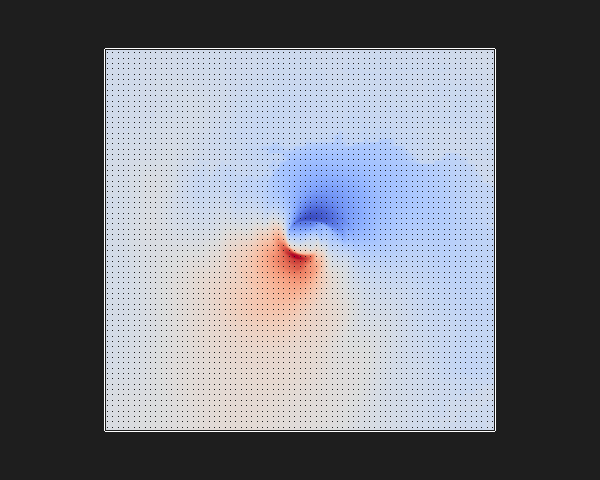

In [8]:
# Show the rendering
ses.GetCamera().ViewAll()
ses.Show()

In [9]:
ses.DeleteRenderer(ren)

The same process can be used to render a 3D variable

In [10]:
data.AddXArrayData("U", ds["U"].squeeze("Time"))

In [11]:
ren = data.NewRenderer(renderer.WireFrameRenderer)
ren.SetVariableName("U")
ses.GetCamera().LookAt([ 138.64364963, -213.94716727,  293.46022828],
                       [157., 154.,   0.],
                       [0.04815987, 0.62133843, 0.78206086])

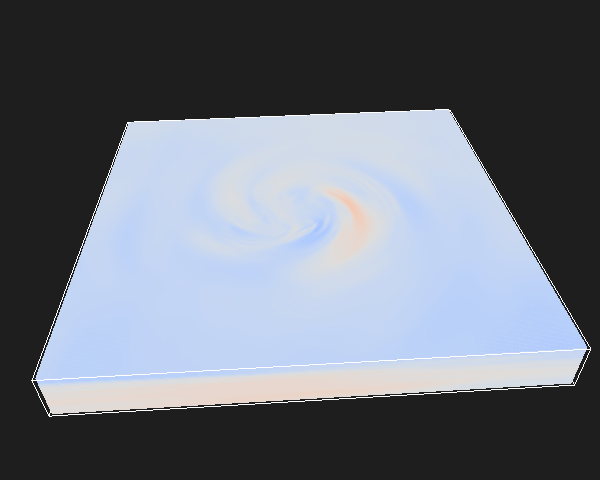

In [12]:
ses.Show()